## Objective

The objective of this notebook is to solve the third programming assignment of Andrew Ng's Machine Learning course on Coursera using Python. I have also taken a snapshot of the important concepts relating to the topics taught in this week that I'll be pasting in my notebook.

In [1]:
from IPython.display import Image

## Multiclass Classification Overview

![title](Multiclass Classification.png)

In [2]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from scipy.io import loadmat
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#To read the matlab matrix in Python
data = loadmat('ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
X=data['X']
y=data['y']
print('The dimension of the matrices X and Y are',X.shape,'and',y.shape,'respectively.')
print('The number of unique values in y are:',np.unique(y))

The dimension of the matrices X and Y are (5000, 400) and (5000, 1) respectively.
The number of unique values in y are: [ 1  2  3  4  5  6  7  8  9 10]


Every row in the matrix is an image. The dimension of every image is 20x20 and these 400 pixels have been unrolled into one vector, thus the dimension of the matrix is 5000x400. y has 5000 labels - the class to which every picture belongs. Now, pictures with 0 have the class label 10. This has been done for the purpose of this course as indexing in MATLAB starts from 1.

In [5]:
#We'll change this in python
y=np.where(y==10,0,y)

The label is 0


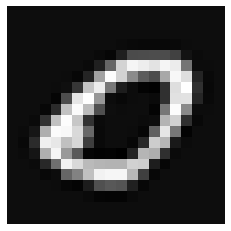

In [6]:
#To show the X and y for one particular image
plt.imshow(X[0].reshape(20,20),cmap='gray')
plt.xticks([])
plt.yticks([])
print('The label is',y[0][0])

In [7]:
#To add an additional column. Why is it needed? Since we're trying to perform matrix multiplications, it is 
#necessary that the conditions for matrix multiplication are satisfied. Since theta 0 doesn't have a 
#corresponding column in X, to be consistent we need to have an additional column that only has ones
X=np.hstack((np.ones((X.shape[0],1)),X))
theta=np.zeros(X.shape[1]) #Initial value of theta

In [8]:
def SIGMOID(z):
    #Using np.exp is beneficial as it does the operation in a vectorised manner
    return(1/(1+np.exp(-z)))

In [9]:
def COSTREG(theta,X,y,lam):
    m=X.shape[0]
    n=X.shape[1]
    theta=theta.reshape(n,1)
    hypothesis=SIGMOID(np.dot(X,theta))
    J=(-1/m)*((np.dot(np.transpose(y),np.log(hypothesis)))+
              (np.dot((1-np.transpose(y)),np.log(1-hypothesis))))+(lam/(2*m))*np.sum(np.square(theta[1:]))
    return(J.flatten()[0])

Explanation:

- The COSTREG function calculates the regularized cost of our logistic regression classifier with respect to the thetas (parameters)
- m is the number of rows in the design matrix (X)
- n is the number of features in the original X plus 1
- we first take a dot product of our X and theta (initial values set to 0). X is an (m x n) dimensional matrix, theta is a n dimensional vector. The result of the dot product gives us an m dimensional vector (our hypothesis)
- y is the label which is an m dimesnional vector 
- We then take the transpose of y which becomes a (1 x m) matrix and then take the dot product of this transpose with the log of the hypothesis (m x 1) matrix
- The result gives us our cost for y=1. We do the exact same operation for cost when y=0 as well and add the two terms
- However in this case, we also have our regularization parameter lambda. We don't regularize the zeroth theta which is our intercept term. We square and sum over all other terms
- The result of these operations gives us our final cost which we try to minimze with respect to theta

In [10]:
def GRADREG(theta,X,y,lam):
    m=X.shape[0]
    n=X.shape[1]
    theta=theta.reshape(n,1)
    hypothesis=SIGMOID(np.dot(X,theta))
    grad=(1/m)*(np.dot(np.transpose(X),(hypothesis-y)))+np.insert((lam/m)*(theta[1:]),0,0).reshape(n,1)
    return(grad.flatten())

Explanation:

- The GRADREG function calculates the gradient of the regularized cost function
- The gradient looks similar to the gradient of the linear regression cost function, however the key difference in the hypothesis
- We take a transpose of X, so that we get a (n x m) dimensional matrix
- (hypotheis - y) is an (m x 1) dimensional matrix
- The result of the dot product of the two gives us an n dimensional vector, that comes in handy in updating the value of theta.
- However in this case, we also have our regularization parameter lambda. We don't regularize the zeroth theta which is our intercept term
- We multiply all our thetas starting from index 1 by lambda/m
- Since the zeroth term in theta is exempt from regularization, we need to set it to zero in the second half of the equation to be consistent with the dimensions for which we use the np.insert function. DON'T SET IT TO theta[0] as this will mean that after every iteration of an optimization algorithm, theta[0] at the end of the previous iteration will get added to theta[0] of the new iteration

In [11]:
#Using the scipy's optimize module, we make use of Truncated Newton Method to optimize our thetas. Note : It is
#important that the parameters passed in the COST and GRAD function are in the order - theta, X and y. You could
#spend hours debugging the error if the parameters are not in that order
import scipy.optimize as opt

In [12]:
def onevsall(X,y,k,theta,lam):
    m=X.shape[0]
    n=X.shape[1]
    thetas=[]
    for i in range(k):
        final_theta=opt.fmin_tnc(func=COSTREG, x0=theta, fprime=GRADREG, args=(X,np.where(y==i,1,0),lam))[0]
        thetas.append(final_theta)
    thetas=np.array(thetas).T
    return(thetas)

In [13]:
thetas=onevsall(X,y,10,theta,0.1)

Explanation:

- In multiclass classification, we train k classifiers for k classes
- We run a for loop, looping from the 0th to the kth class
- We store the value of y as a boolean array, where in the ith iteration we only have two unique values in y - 0 and i
- On every iteration, we basically lump all of our training data in these two classes - 0 and i and find the optimal value of theta (final_theta) that minimizes the cost for the ith logistic regression classifier
- These thetas are then appended to a list (thetas) and converted to a numpy array
- The thetas have the dimension (k x n), where we have the parameters for k logistic regression classifiers on every row
- We return the transpose of this matrix which has the dimensions (n x k)

In [14]:
def pred_multiclass(thetas,X):
    predictions=SIGMOID(np.dot(X,thetas))
    final_pred=np.argmax(predictions,axis=1)
    return(final_pred)

Explanation:

- Once we get the thetas matrix, we mutliply (take a dot product) of X which as a dimension of (5000 x 401) and thetas (401 x 10)
- We then store the result in a matrix called final_pred (5000 x 10) 
- Our job here is to pick the classifier that has the maximum value of hypothesis 
- If we had 3 classes and the hypotheses of the three classifiers were [0.3 0.9 0.5], we would pick the second classifier's prediction here as it seems to be confident about it's prediction. Hence the predicted class label in this case would be 1 (since 0.9's index is 1)

In [15]:
print('The accuracy of the classifier is',np.mean(pred_multiclass(thetas,X)==y.flatten())*100,'%')

The accuracy of the classifier is 96.46 %


## Neural Networks

You could add more features (such as polynomial features) to logistic regression, but that can be very expensive to train. Hence we use neural networks in this part of the exercise. Neural networks offers an alternate way to perform machine learning when we have complex hypotheses with many features. Adding intermediate layers in neural networks allows us to more elegantly produce interesting and more complex non-linear hypotheses.

![title](NN Model Representation.png)

![title](NN Model Representation 2.png)

Each layer gets its own matrix of weights, Θ(j).

The dimensions of these matrices of weights is determined as follows:

- If network has s(j) units in layer j and s(j+1) units in layer j+1, then Θ(j) will be of dimension s(j+1)×(s(j)+1) 
- The +1 comes from the addition in Θ(j) of the "bias nodes," x0. In other words the output nodes will not include the bias nodes while the inputs will

![title](NN Model Representation 3.png)

In [16]:
X=data['X']
y=data['y']
print('The dimension of the matrices X and Y are',X.shape,'and',y.shape,'respectively.')
print('The number of unique values in y are:',np.unique(y))

The dimension of the matrices X and Y are (5000, 400) and (5000, 1) respectively.
The number of unique values in y are: [ 1  2  3  4  5  6  7  8  9 10]


In [17]:
#To load the MATLAB file onto Python
weights = loadmat('ex3weights.mat')
Theta1=weights['Theta1']
Theta2=weights['Theta2']

In [18]:
print('The dimensions of Theta1 and Theta2 are',Theta1.shape,'and',Theta2.shape,'respectively.')

The dimensions of Theta1 and Theta2 are (25, 401) and (10, 26) respectively.


![title](NN Model.png)

In [19]:
def predict_nn(X,Theta1,Theta2):
    m=X.shape[0]
    a1=np.hstack((np.ones((m,1)),X))
    z2=np.dot(a1,Theta1.T)
    a2=SIGMOID(z2)
    a2=np.hstack((np.ones((m,1)),a2))
    z3=np.dot(a2,Theta2.T)
    a3=SIGMOID(z3)
    predictions=np.argmax(a3,axis=1)+1
    return(predictions)

Explanation:

- a1(X) is a matrix of dimension (m x n+1)
- z2 is a dot product of a1 and transpose of Theta1
- a2 is the activation in the second layer and is = g(z2)
- We then add a column of 1s that represents the bias node in the second layer
- z3 is a dot product of a2 and transpose of Theta2
- a3 is the final hypothesis and = g(z3)
- Like in the multiclass classification problem we choose the classifier that has the maximum value for the hypothesis

In [20]:
print('The accuracy of the classifier is',np.mean(predict_nn(X,Theta1,Theta2)==y.flatten())*100,'%')

The accuracy of the classifier is 97.52 %
